In [136]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import tifffile
import matplotlib.pyplot as plt

PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]

%matplotlib inline

# Init data sizes and parametes of the PXM of ID16A

In [137]:
n = 2048  # object size in each dimension
ntheta = 1  # number of angles (rotations)

pn = 64  # tomography chunk size for GPU processing
ptheta = 1  # holography chunk size for GPU processing

center = n/2  # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

# ID16a setup
voxelsize = 10e-9*2048/n  # object voxel size
energy = 17.05  # [keV] xray energy
wavelength = PLANCK_CONSTANT * SPEED_OF_LIGHT / energy
focusToDetectorDistance = 1.28
ndist = 3
sx0 = 3.7e-4
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
z1[:] = z1[0]
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = 270e-3# positions of the probe and code for reconstruction
z2p = z1-z1p
# magnification when propagating from the probe plane to the detector
magnificationsp = z1/z1p
# propagation distances after switching from the point source wave to plane wave,
distancesp = (z1p*z2p)/z1

norm_magnificationsp = magnificationsp/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distancesp = distancesp*norm_magnificationsp**2
distancesp = distancesp*(z1p/z1)**2

print(distances, distancesp)
print(distances+ distancesp)


[0.00420013 0.00420013 0.00420013] [-0.00414823 -0.00414823 -0.00414823]
[5.18963367e-05 5.18963367e-05 5.18963367e-05]


## Read data

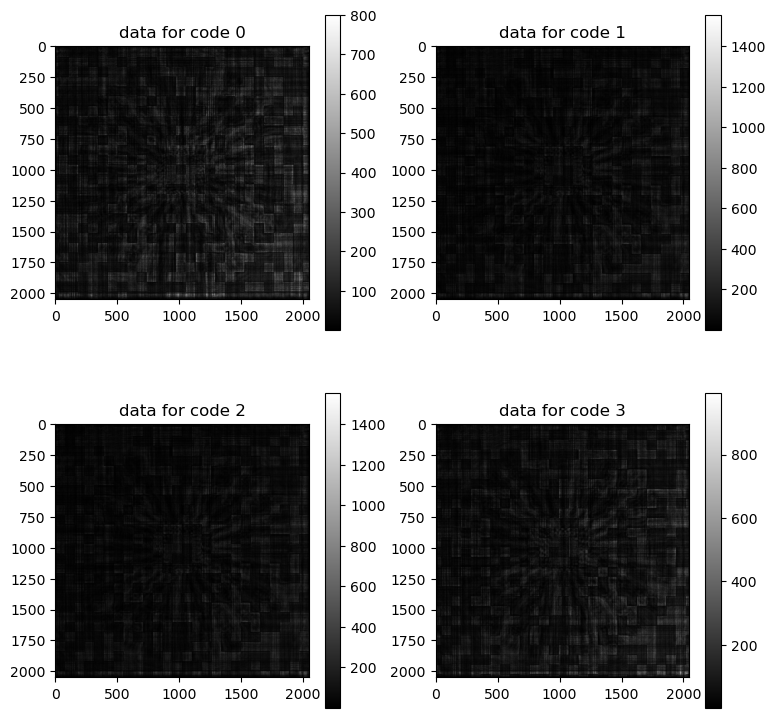

In [138]:
data = np.zeros([ndist,ntheta,n,n],dtype='float32')
for k in range(ndist):
    data[k] = dxchange.read_tiff(f'data/modeling/data_siemens_codes_{n}_{k}.tiff')
ref = dxchange.read_tiff(f'data/modeling/ref_siemens_codes_{n}_0')

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0],cmap='gray')
axs[0,0].set_title('data for code 0')
fig.colorbar(im)
im=axs[0,1].imshow(data[1,0],cmap='gray')
axs[0,1].set_title('data for code 1')
fig.colorbar(im)
im=axs[1,0].imshow(data[-2,0],cmap='gray')
axs[1,0].set_title('data for code 2')
fig.colorbar(im)
im=axs[1,1].imshow(data[-1,0],cmap='gray')
axs[1,1].set_title('data for code 3')
fig.colorbar(im)

## Read the probe

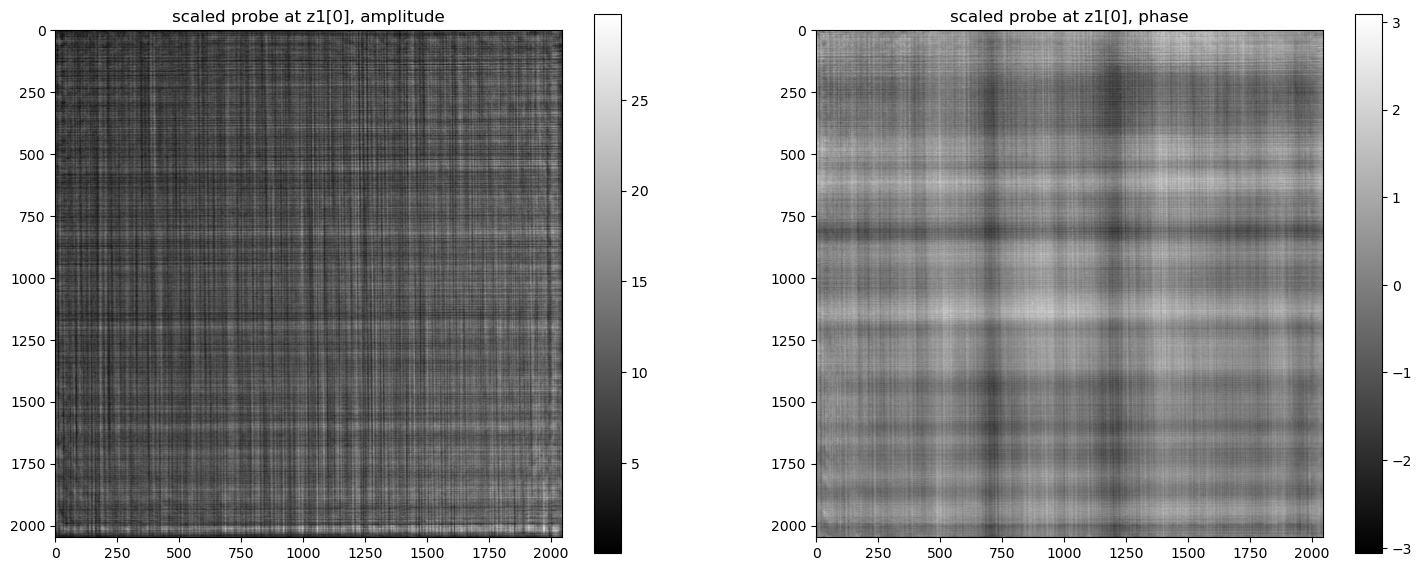

In [139]:
prb = np.ones([1,n,n],dtype='complex64')
prb[:] = (tifffile.imread(f'data/prb_id16a/prb_abs_{n}.tiff')*np.exp(1j* tifffile.imread(f'data/prb_id16a/prb_phase_{n}.tiff')))[0]
# prb[:] = 1
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
im=axs[0].imshow(np.abs(prb[0]),cmap='gray')
axs[0].set_title('scaled probe at z1[0], amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(prb[0]),cmap='gray')
axs[1].set_title('scaled probe at z1[0], phase')
fig.colorbar(im)

## Read the transmittance functions for the codes

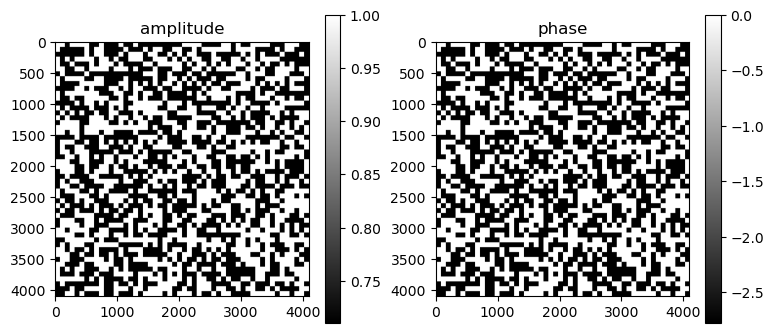

In [140]:
psiill = np.ones([1,2*n,2*n],dtype='complex64')
psiill[0] = (tifffile.imread(f'data/modeling/psiill_abs_{n}.tiff')*np.exp(1j* tifffile.imread(f'data/modeling/psiill_angle_{n}.tiff')))
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psiill[0]),cmap='gray')
axs[0].set_title('amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psiill[0]),cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im)

## Create a solver class for holography, note the class has additional parameters distances2 to be able to compute Fresnel propagation between the sample and probe

In [141]:
pslv = holotomo.SolverHolo(ntheta, n, ptheta, voxelsize, energy, distances, norm_magnifications, distancesp)
pslv0 = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances[:1], norm_magnifications[:1], distancesp[:1]) 


# Read codes

In [142]:
shifts = np.load('shifts.npy')
shifts_code = np.load('shifts_code.npy')

## Conjugate gradient solver

In [143]:
import cupy as cp

def line_search(minf, gamma, fu, fu0, fd, fd0):
    """ Line search for the step sizes gamma"""
    while(minf(fu,fu0)-minf(fu+gamma*fd, fu0+gamma*fd0) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma


def cg_holo(pslv, pslv0, data, data_ref, init, init_prb,  piter,shifts, codes, shifts_code, upd_psi=True, upd_prb=False,step=1,vis_step=1):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(fpsi,fprb):
        f = cp.linalg.norm(cp.abs(fpsi)-cp.sqrt(data))**2            
        # f += cp.linalg.norm(cp.abs(fprb)-cp.sqrt(data_ref))**2        
        # f = cp.linalg.norm(cp.abs(fpsi)**2-data)**2            
        return f        
    psi = init.copy()
    prb = init_prb.copy()
    gammapsi = 1
    gammaprb = 1
    conv = np.zeros(piter)
    for i in range(piter):
        if upd_psi:
            
            fpsi = pslv.fwd_holo(psi,prb,shifts,codes,shifts_code)          
            grad = pslv.adj_holo(fpsi-cp.sqrt(data)*cp.exp(1j*(cp.angle(fpsi))), prb,shifts,codes,shifts_code)/cp.max(cp.abs(prb))**2#/ndist**2
            # d = -grad    
            # Dai-Yuan direction
            if i == 0:
                d = -grad
            else:
                d = -grad+cp.linalg.norm(grad)**2 / \
                    ((cp.sum(cp.conj(d)*(grad-grad0))))*d
            grad0 = grad
            # line search
            fd = pslv.fwd_holo(d, prb,shifts,codes,shifts_code)          
            gammapsi = line_search(minf, 1, fpsi, 0, fd, 0)
            psi = psi+gammapsi*d
            
        if upd_prb:
            fprb = pslv.fwd_holo(psi,prb,shifts,codes,shifts_code)          
            fprb0 = pslv0.fwd_holo(psi*0+1,prb,shifts*0,codes,shifts_code*0)       
            
            gradprb = pslv.adj_holo_prb(fprb-cp.sqrt(data)*cp.exp(1j*cp.angle(fprb)),psi,shifts,codes,shifts_code)/cp.max(cp.abs(psi))**2/pslv.ntheta#/ndist**2
            gradprb += pslv0.adj_holo_prb(fprb0-cp.sqrt(data_ref)*cp.exp(1j*cp.angle(fprb0)),psi*0+1,shifts*0,codes,shifts_code)       
            gradprb*=0.5
            dprb = -gradprb
            # gradprb0 = gradprb
            # line search
            fdprb = pslv.fwd_holo(psi, dprb,shifts,codes,shifts_code)       
            fdprb0 = pslv0.fwd_holo(psi*0+1, dprb,shifts*0,codes,shifts_code*0)       
            
            gammaprb = line_search(minf, 1, fprb, fprb0, fdprb, fdprb0)
            prb = prb + gammaprb*dprb
            
        if i%step==0:
            fprb = pslv.fwd_holo(psi,prb,shifts,codes,shifts_code)       
            fprb0 = pslv0.fwd_holo(psi*0+1,prb,shifts*0,codes,shifts_code*0)                   
            err=minf(fprb,fprb0)
            conv[i]=err
            print(f'{i}) {gammapsi=} {gammaprb=}, {err=:1.5e}')  
    
        if i%vis_step==0:  
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            im=axs[0].imshow(np.abs(psi[0,n//2:3*n//2,n//2:3*n//2].get()),cmap='gray')
            axs[0].set_title('reconstructed amplitude')
            fig.colorbar(im)
            im=axs[1].imshow(np.angle(psi[0,n//2:3*n//2,n//2:3*n//2].get()),cmap='gray')
            axs[1].set_title('reconstructed phase')
            fig.colorbar(im)
            
            plt.show()
        
    return psi,prb,conv

def cg_holo_batch(pslv, pslv0, data,data_ref, init, prb_init, piter,shifts=None,codes=None,shifts_code=None,upd_psi=True,upd_prb=False,step=1,vis_step=1):
    """Batch of CG solvers"""
    
    res = np.zeros([pslv.ntheta, 2*pslv.n, 2*pslv.n], dtype='complex64')
    prb_init_gpu = cp.array(prb_init)                
    codes_gpu = cp.array(codes)                
    data_ref_gpu = cp.array(data_ref)

        
    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,ids])        
        init_gpu = cp.array(init[ids])
        shifts_gpu = cp.array(shifts[:,ids])
        shifts_code_gpu = cp.array(shifts_code[:,ids])
            
        # Radon transform
        res_gpu,res_prb_gpu,conv = cg_holo(pslv, pslv0, data_gpu,data_ref_gpu, init_gpu,prb_init_gpu, piter,
                                      shifts_gpu,codes_gpu, shifts_code_gpu, upd_psi, upd_prb,step,vis_step)
        # copy result to cpu
        res[ids] = res_gpu.get()
        res_prb = res_prb_gpu.get()
    return res,res_prb,conv




0) gammapsi=1 gammaprb=1, err=1.21709e+07


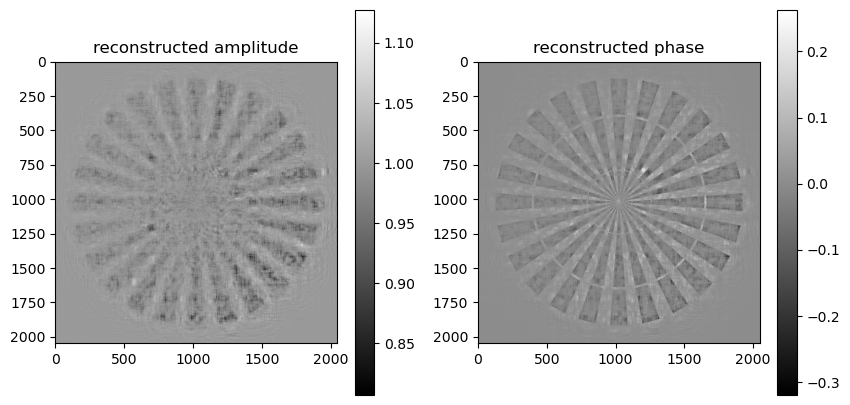

1) gammapsi=1 gammaprb=1, err=4.96717e+06
2) gammapsi=1 gammaprb=1, err=3.76401e+06
3) gammapsi=1 gammaprb=1, err=2.23695e+06
4) gammapsi=1 gammaprb=1, err=1.83468e+06
5) gammapsi=1 gammaprb=1, err=1.28505e+06
6) gammapsi=1 gammaprb=1, err=1.09571e+06
7) gammapsi=1 gammaprb=1, err=8.35240e+05
8) gammapsi=1 gammaprb=1, err=7.28002e+05
9) gammapsi=1 gammaprb=1, err=5.83006e+05
10) gammapsi=1 gammaprb=1, err=5.15925e+05
11) gammapsi=1 gammaprb=1, err=4.27547e+05
12) gammapsi=1 gammaprb=1, err=3.81535e+05
13) gammapsi=1 gammaprb=1, err=3.25882e+05
14) gammapsi=1 gammaprb=1, err=2.92468e+05
15) gammapsi=1 gammaprb=1, err=2.53428e+05
16) gammapsi=1 gammaprb=1, err=2.29832e+05
17) gammapsi=1 gammaprb=1, err=1.99081e+05
18) gammapsi=1 gammaprb=1, err=1.82261e+05
19) gammapsi=1 gammaprb=1, err=1.58676e+05
20) gammapsi=1 gammaprb=1, err=1.45728e+05
21) gammapsi=1 gammaprb=1, err=1.28429e+05
22) gammapsi=1 gammaprb=1, err=1.18155e+05
23) gammapsi=1 gammaprb=1, err=1.04749e+05
24) gammapsi=1 gamma

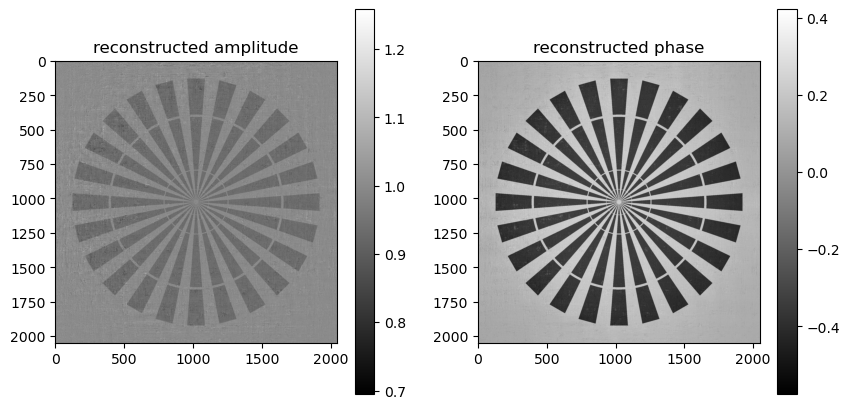

33) gammapsi=1 gammaprb=1, err=4.34758e+04
34) gammapsi=1 gammaprb=1, err=3.92627e+04
35) gammapsi=1 gammaprb=1, err=3.70087e+04
36) gammapsi=1 gammaprb=1, err=3.35833e+04
37) gammapsi=1 gammaprb=1, err=3.17930e+04
38) gammapsi=1 gammaprb=1, err=2.95083e+04
39) gammapsi=1 gammaprb=1, err=2.78186e+04
40) gammapsi=1 gammaprb=1, err=2.63661e+04
41) gammapsi=1 gammaprb=1, err=2.47011e+04
42) gammapsi=1 gammaprb=1, err=2.37361e+04
43) gammapsi=1 gammaprb=1, err=2.24663e+04
44) gammapsi=1 gammaprb=1, err=2.16400e+04
45) gammapsi=1 gammaprb=1, err=2.08087e+04
46) gammapsi=1 gammaprb=1, err=1.99502e+04
47) gammapsi=1 gammaprb=1, err=1.93882e+04
48) gammapsi=1 gammaprb=1, err=1.86770e+04
49) gammapsi=1 gammaprb=1, err=1.81185e+04
50) gammapsi=1 gammaprb=1, err=1.76345e+04
51) gammapsi=1 gammaprb=1, err=1.69516e+04
52) gammapsi=1 gammaprb=1, err=1.65850e+04
53) gammapsi=1 gammaprb=1, err=1.61345e+04
54) gammapsi=1 gammaprb=1, err=1.55868e+04
55) gammapsi=1 gammaprb=1, err=1.52381e+04
56) gammaps

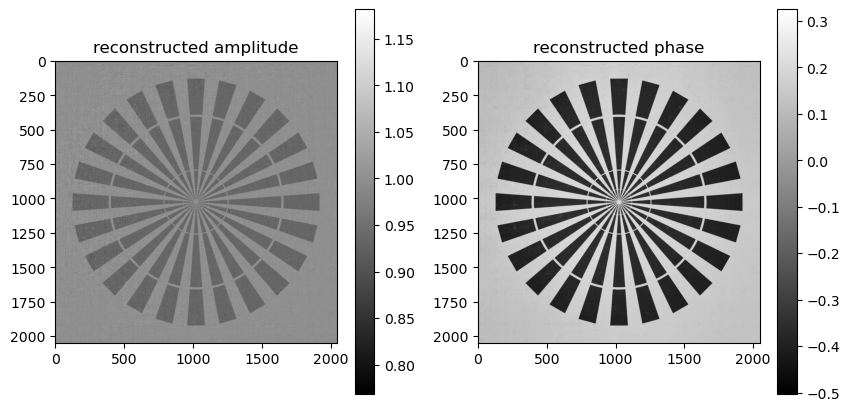

65) gammapsi=1 gammaprb=1, err=1.02124e+04
66) gammapsi=1 gammaprb=1, err=9.48812e+03
67) gammapsi=1 gammaprb=1, err=8.93550e+03
68) gammapsi=0.5 gammaprb=1, err=8.88596e+03
69) gammapsi=1 gammaprb=1, err=8.32078e+03
70) gammapsi=1 gammaprb=1, err=8.03070e+03
71) gammapsi=1 gammaprb=1, err=7.51476e+03
72) gammapsi=1 gammaprb=1, err=7.29011e+03
73) gammapsi=1 gammaprb=1, err=6.63642e+03
74) gammapsi=1 gammaprb=1, err=6.37623e+03
75) gammapsi=1 gammaprb=1, err=6.09038e+03
76) gammapsi=1 gammaprb=1, err=5.93749e+03
77) gammapsi=1 gammaprb=1, err=5.57580e+03
78) gammapsi=1 gammaprb=1, err=5.33111e+03
79) gammapsi=1 gammaprb=1, err=5.11873e+03
80) gammapsi=1 gammaprb=1, err=4.87854e+03
81) gammapsi=1 gammaprb=1, err=4.70560e+03
82) gammapsi=1 gammaprb=1, err=4.45819e+03
83) gammapsi=1 gammaprb=1, err=4.32584e+03
84) gammapsi=1 gammaprb=1, err=4.07344e+03
85) gammapsi=1 gammaprb=1, err=3.96504e+03
86) gammapsi=1 gammaprb=1, err=3.79741e+03
87) gammapsi=1 gammaprb=1, err=3.67568e+03
88) gamma

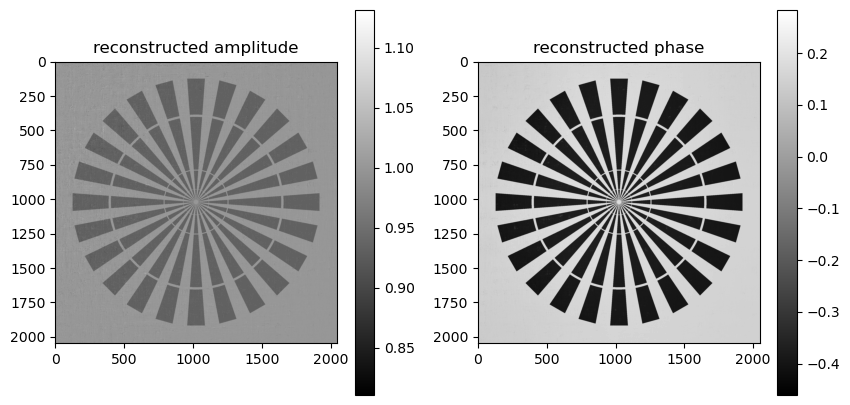

97) gammapsi=1 gammaprb=1, err=2.70974e+03
98) gammapsi=1 gammaprb=1, err=2.64559e+03
99) gammapsi=1 gammaprb=1, err=2.47509e+03
100) gammapsi=1 gammaprb=1, err=2.37175e+03
101) gammapsi=1 gammaprb=1, err=2.30137e+03
102) gammapsi=1 gammaprb=1, err=2.25832e+03
103) gammapsi=1 gammaprb=1, err=2.16121e+03
104) gammapsi=1 gammaprb=1, err=2.11957e+03
105) gammapsi=1 gammaprb=1, err=2.06037e+03
106) gammapsi=1 gammaprb=1, err=1.99687e+03
107) gammapsi=1 gammaprb=1, err=1.94469e+03
108) gammapsi=1 gammaprb=1, err=1.90130e+03
109) gammapsi=1 gammaprb=1, err=1.84022e+03
110) gammapsi=1 gammaprb=1, err=1.80874e+03
111) gammapsi=1 gammaprb=1, err=1.75741e+03
112) gammapsi=1 gammaprb=1, err=1.71197e+03
113) gammapsi=1 gammaprb=1, err=1.67350e+03
114) gammapsi=1 gammaprb=1, err=1.58581e+03
115) gammapsi=1 gammaprb=1, err=1.54623e+03
116) gammapsi=1 gammaprb=1, err=1.50927e+03
117) gammapsi=1 gammaprb=1, err=1.46212e+03
118) gammapsi=1 gammaprb=1, err=1.40878e+03
119) gammapsi=1 gammaprb=1, err=1.3

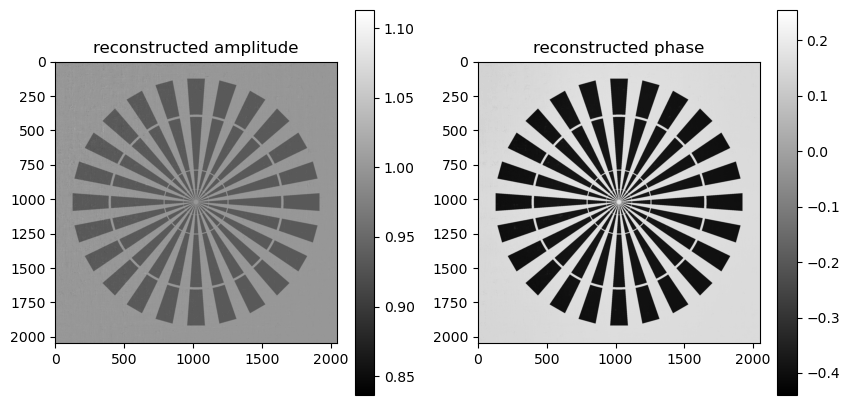

129) gammapsi=1 gammaprb=1, err=1.06023e+03
130) gammapsi=1 gammaprb=1, err=1.03960e+03
131) gammapsi=1 gammaprb=1, err=1.01721e+03
132) gammapsi=1 gammaprb=1, err=9.98912e+02
133) gammapsi=1 gammaprb=1, err=9.79447e+02
134) gammapsi=1 gammaprb=1, err=9.59798e+02
135) gammapsi=1 gammaprb=1, err=9.43951e+02
136) gammapsi=1 gammaprb=1, err=9.19572e+02
137) gammapsi=1 gammaprb=1, err=9.06098e+02
138) gammapsi=1 gammaprb=1, err=8.88954e+02
139) gammapsi=1 gammaprb=1, err=8.70964e+02
140) gammapsi=1 gammaprb=1, err=8.62775e+02
141) gammapsi=1 gammaprb=1, err=8.22075e+02
142) gammapsi=1 gammaprb=1, err=8.07908e+02
143) gammapsi=0.25 gammaprb=1, err=8.04342e+02
144) gammapsi=1 gammaprb=1, err=7.69699e+02
145) gammapsi=1 gammaprb=1, err=7.58257e+02
146) gammapsi=0.5 gammaprb=1, err=7.26978e+02
147) gammapsi=1 gammaprb=1, err=7.09463e+02
148) gammapsi=1 gammaprb=1, err=6.85108e+02
149) gammapsi=1 gammaprb=1, err=6.66036e+02
150) gammapsi=1 gammaprb=1, err=6.48053e+02
151) gammapsi=1 gammaprb=1,

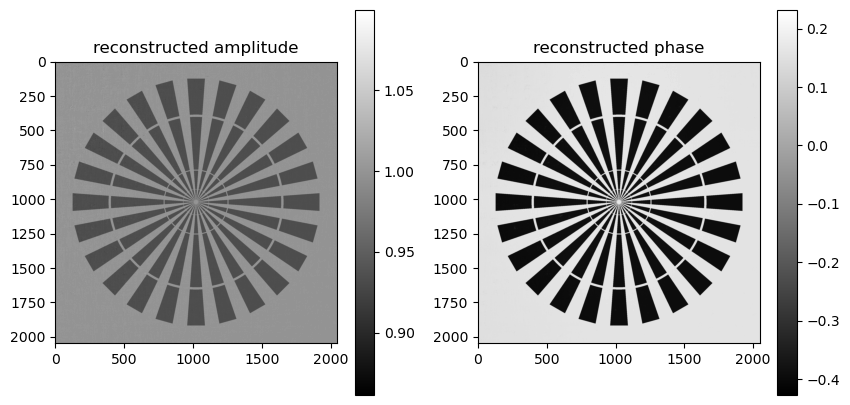

161) gammapsi=1 gammaprb=1, err=4.22309e+02
162) gammapsi=1 gammaprb=1, err=4.11650e+02
163) gammapsi=1 gammaprb=1, err=3.97643e+02
164) gammapsi=1 gammaprb=1, err=3.90172e+02
165) gammapsi=1 gammaprb=1, err=3.80059e+02
166) gammapsi=1 gammaprb=1, err=3.71606e+02
167) gammapsi=1 gammaprb=1, err=3.64275e+02
168) gammapsi=1 gammaprb=1, err=3.54437e+02
169) gammapsi=1 gammaprb=1, err=3.48365e+02
170) gammapsi=1 gammaprb=1, err=3.41759e+02
171) gammapsi=1 gammaprb=1, err=3.32257e+02
172) gammapsi=1 gammaprb=1, err=3.26617e+02
173) gammapsi=1 gammaprb=1, err=3.14470e+02
174) gammapsi=1 gammaprb=1, err=3.07016e+02
175) gammapsi=1 gammaprb=1, err=2.97818e+02
176) gammapsi=1 gammaprb=1, err=2.86281e+02
177) gammapsi=1 gammaprb=1, err=2.82118e+02
178) gammapsi=1 gammaprb=1, err=2.70163e+02
179) gammapsi=1 gammaprb=1, err=2.64909e+02
180) gammapsi=1 gammaprb=1, err=2.56253e+02
181) gammapsi=1 gammaprb=1, err=2.50260e+02
182) gammapsi=1 gammaprb=1, err=2.42886e+02
183) gammapsi=1 gammaprb=1, err=

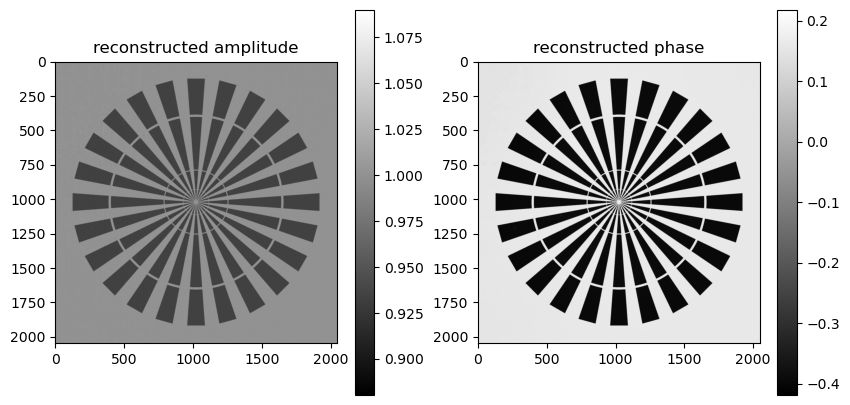

193) gammapsi=1 gammaprb=1, err=1.85850e+02
194) gammapsi=1 gammaprb=1, err=1.81377e+02
195) gammapsi=1 gammaprb=1, err=1.66543e+02
196) gammapsi=1 gammaprb=1, err=1.64905e+02
197) gammapsi=1 gammaprb=1, err=1.59502e+02
198) gammapsi=1 gammaprb=1, err=1.54345e+02
199) gammapsi=1 gammaprb=1, err=1.45787e+02
200) gammapsi=1 gammaprb=1, err=1.42443e+02
201) gammapsi=1 gammaprb=1, err=1.34144e+02
202) gammapsi=1 gammaprb=1, err=1.29986e+02
203) gammapsi=1 gammaprb=1, err=1.22167e+02
204) gammapsi=1 gammaprb=1, err=1.17953e+02
205) gammapsi=1 gammaprb=1, err=1.14464e+02
206) gammapsi=1 gammaprb=1, err=1.11852e+02
207) gammapsi=1 gammaprb=1, err=1.07642e+02
208) gammapsi=1 gammaprb=1, err=1.03010e+02
209) gammapsi=1 gammaprb=1, err=1.00289e+02
210) gammapsi=1 gammaprb=1, err=9.63864e+01
211) gammapsi=1 gammaprb=1, err=9.41427e+01
212) gammapsi=1 gammaprb=1, err=8.92016e+01
213) gammapsi=1 gammaprb=1, err=8.68491e+01
214) gammapsi=1 gammaprb=1, err=8.32876e+01
215) gammapsi=1 gammaprb=1, err=

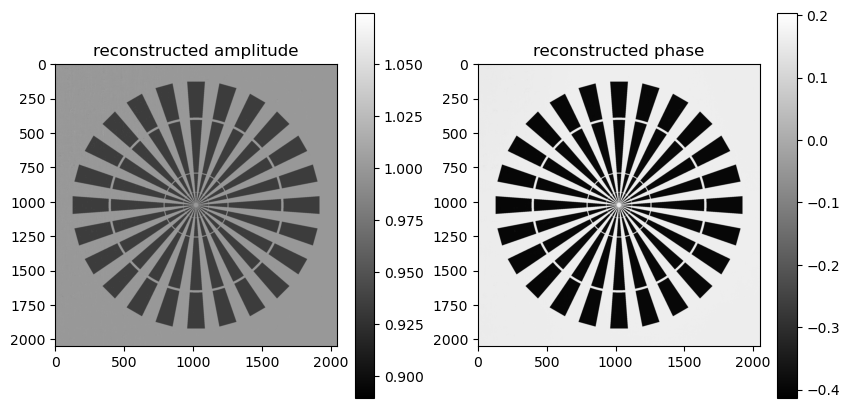

225) gammapsi=1 gammaprb=1, err=6.25344e+01
226) gammapsi=1 gammaprb=1, err=6.11072e+01
227) gammapsi=1 gammaprb=1, err=5.79214e+01
228) gammapsi=1 gammaprb=1, err=5.68209e+01
229) gammapsi=1 gammaprb=1, err=5.56872e+01
230) gammapsi=1 gammaprb=1, err=5.42224e+01
231) gammapsi=1 gammaprb=1, err=5.15148e+01
232) gammapsi=1 gammaprb=1, err=4.90904e+01
233) gammapsi=1 gammaprb=1, err=4.69683e+01
234) gammapsi=1 gammaprb=1, err=4.57663e+01
235) gammapsi=1 gammaprb=1, err=4.45594e+01
236) gammapsi=1 gammaprb=1, err=4.36282e+01
237) gammapsi=1 gammaprb=1, err=4.18646e+01
238) gammapsi=1 gammaprb=1, err=4.02624e+01
239) gammapsi=1 gammaprb=1, err=3.91235e+01
240) gammapsi=1 gammaprb=1, err=3.78160e+01
241) gammapsi=1 gammaprb=1, err=3.71100e+01
242) gammapsi=1 gammaprb=1, err=3.60165e+01
243) gammapsi=1 gammaprb=1, err=3.51155e+01
244) gammapsi=1 gammaprb=1, err=3.43249e+01
245) gammapsi=1 gammaprb=1, err=3.34138e+01
246) gammapsi=1 gammaprb=1, err=3.28455e+01
247) gammapsi=1 gammaprb=1, err=

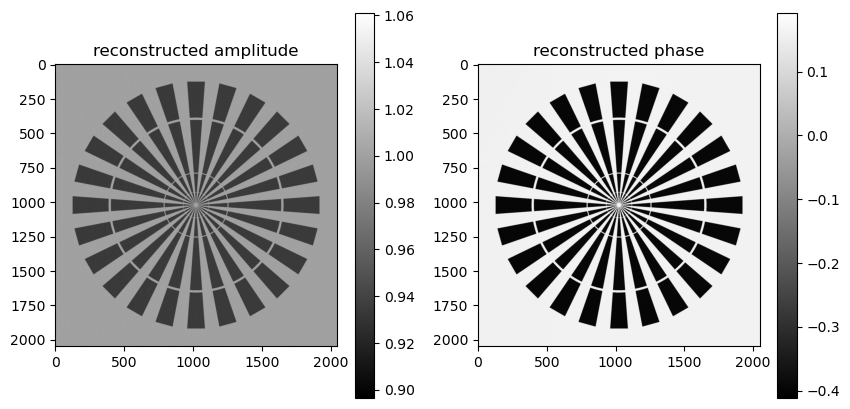

In [144]:
shifts_rec = cp.array(shifts/norm_magnifications[:,np.newaxis,np.newaxis])
rec = np.ones([ntheta,2*n,2*n],dtype='complex64')

# use only the abs value of the probe as initial guess
rec_prb = prb
data_ref = ref
codes = psiill
rec,rec_prb,conv = cg_holo_batch(pslv, pslv0, data, data_ref, rec, rec_prb, 257, shifts_rec, codes, shifts_code, True,False,1,32)


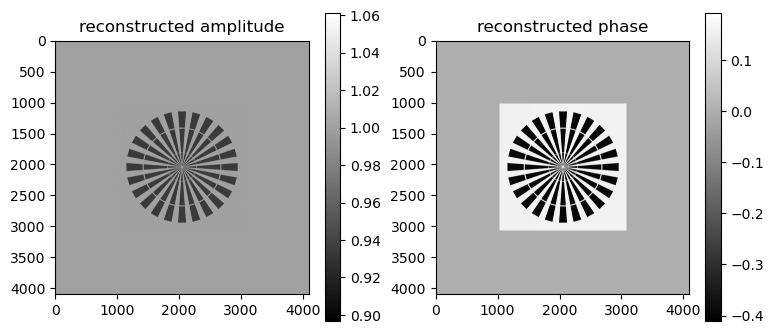

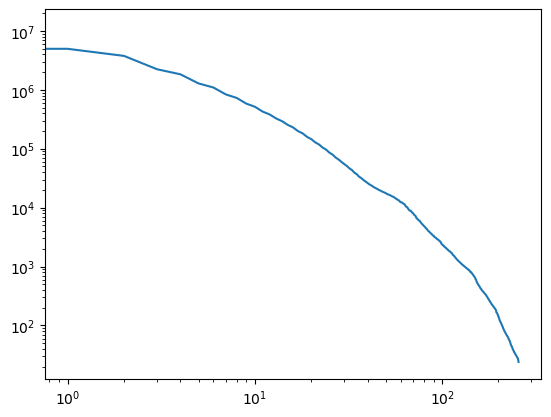

In [148]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(rec[0]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec[0]),cmap='gray')
axs[1].set_title('reconstructed phase')
fig.colorbar(im)
plt.figure()
plt.loglog(conv)




dxchange.write_tiff(np.angle(rec[0]),f'data/modeling/rec_siemens_codes_{n}_0',overwrite=True)
np.save(f'data/modeling/conv_siemens_codes_{n}_0',conv)
